# Convergence of an inference problem in 1D

We are observing a variable over a domain (size $L$).
The variable is composed of the sum of a spatially autocorrelated signal (decorrelation length scale $\lambda$, amplitude $\eta$) and white noise (amplitude $n$).

Observations are either:

- uniform spatially with spatial resolution $\delta$.
- $N$ random distributed observation (uniform distribution) with equivalent resolution $\delta\sim L/N$.

A priori criteria for the correct inference of the signal characteristics are:

- $\delta\ll \lambda \ll L$ or equivalently $\lambda/\delta \gg 1$ and $L / \lambda \gg 1$. The ratio $\lambda / \delta$ quantifies how well the signal is resolved, while the ratio $L / \lambda$ quantifies how many statistically independent realizations of the signal are observed.
- $\eta/n\gg 1$. This is the signal to noise ratio.


In [1]:
from tqdm import tqdm

import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from seaborn import kdeplot

from gptide import cov, GPtideScipy, mcmc
from gptide import stats as gpstats
import corner
import arviz as az

In [2]:
production = True

## set up problem with uniform spatial sampling

Number of data points = 200


Text(0.5, 1.0, 'std=1.543700206778194')

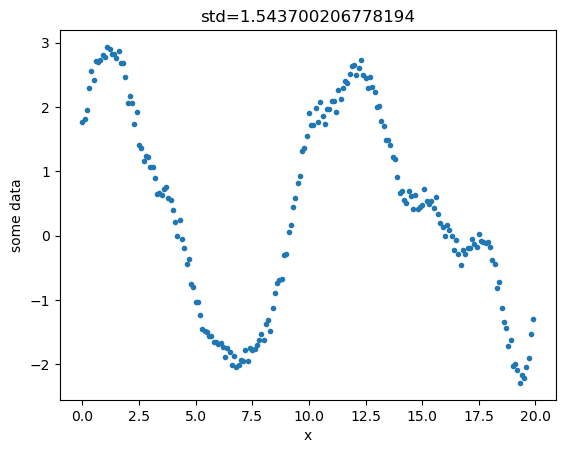

In [3]:
# noise and signal properties
snr = 10. # signal to noise ratio
η = 1. # signal amplitude
λ = 1. # correlation length scale
δ = λ/10 # spatial resolution
L = 20*λ # domain size
covfunc = cov.expquad_1d

# derived variables
noise = η/snr # noise amplitude
covparams = (η, λ)

# spatial location of observations
#xd = np.random.uniform(0., Ld, size=(N,1))
xd = np.arange(0, L, δ)[:,None]
print(f"Number of data points = {xd.size}")

# Initialise the GPtide object and sample from the prior
GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
np.random.seed(0)
yd = GP.prior(samples=1)

plt.figure()
plt.plot(xd, yd,'.')
plt.ylabel('some data')
plt.xlabel('x')
plt.title(f"std={np.std(yd)}")

In [4]:
# iηitial guess of the noise and covariance parameters (these can matter)

noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, 5*noise) # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(η, η*2, η/10, 10*η),     # η - true value 1.
                    gpstats.truncnorm(λ, λ*2, λ/10, 10*λ)    # ℓ - true value 0.1
                   ]

samples, log_prob, priors_out, sampler = mcmc.mcmc( xd,
                                                    yd,
                                                    covfunc,
                                                    covparams_priors,
                                                    noise_prior,
                                                    nwarmup=100,
                                                    niter=100,
                                                    verbose=False,
                                                    nwalkers=60,
                                                  )

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]


In [5]:
# Find sample with highest log prob
i = np.argmax(log_prob)
MAP = samples[i, :]

print('noise (true): {:3.2f}, noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η (true): {:3.2f}, η (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('λ (true): {:3.2f}, λ (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))

noise (true): 0.10, noise (mcmc): 0.10
η (true): 1.00, η (mcmc): 1.44
λ (true): 1.00, λ (mcmc): 1.22


/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


0.1 Axes(0.125,0.11;0.227941x0.77)
1.0 Axes(0.398529,0.11;0.227941x0.77)
1.0 Axes(0.672059,0.11;0.227941x0.77)


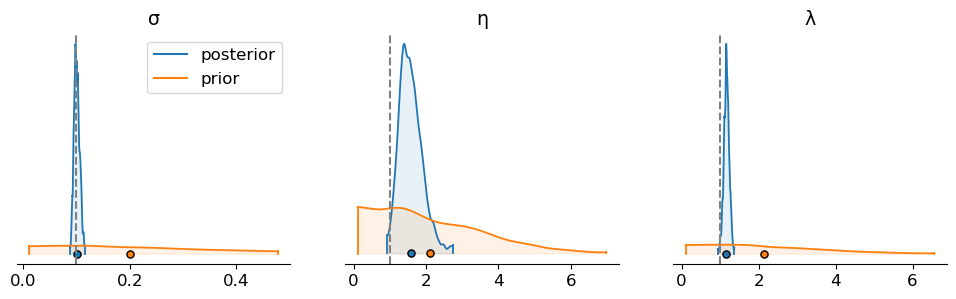

In [6]:
# posterior density plot

labels = ['σ','η','λ']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels],
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 3),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

for t, ax in zip([noise,]+list(covparams), axs[0]):
    print(t, ax)
    ax.axvline(t, color="0.5", ls="--")

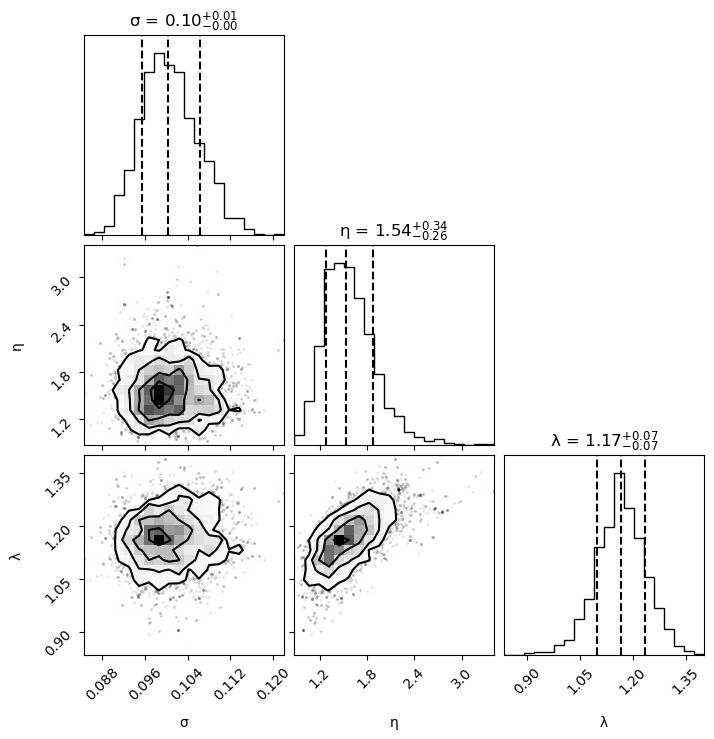

In [7]:
fig = corner.corner(samples,
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

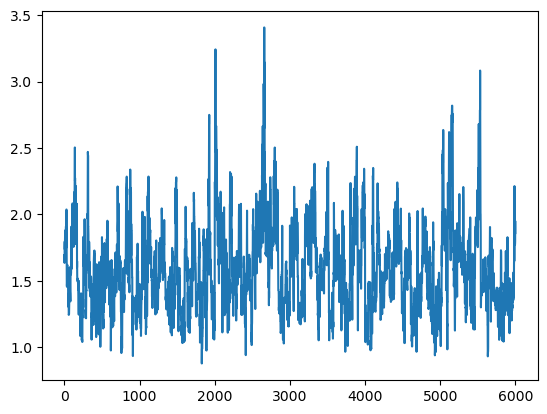

In [8]:
plt.plot(samples[:,1])

(array([105., 123.,  81.,  70.,  55.,  30.,  20.,  10.,   3.,   3.]),
 array([0.10137255, 0.85050284, 1.59963314, 2.34876344, 3.09789374,
        3.84702404, 4.59615434, 5.34528464, 6.09441494, 6.84354524,
        7.59267554]),
 <BarContainer object of 10 artists>)

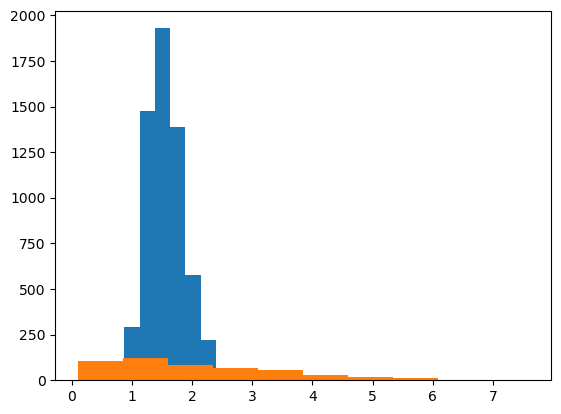

In [9]:
plt.hist(samples[:,1])
plt.hist(priors_out[:,1])

---
## domain size (L) sensitivity

Central result: continuous convergence occurs after $L\sim 20$ to $30\lambda$


In [47]:
def run_inference_experiment(δ=0.1, L=50, snr=10., sampling="uniform"):
    """
    
    Note: \delta and L are assumed to be provided in non-dimensional formed
    """

    nc = f"data/convergence_1D_{sampling}_{δ}_{L}.nc"
    if not production:
        return xr.open_dataset(nc)
    
    # noise and signal properties
    η = 1. # signal amplitude
    λ = 1. # correlation length scale
    δ = δ*λ # spatial resolution
    L = L*λ # domain size
    covfunc = cov.expquad_1d

    # derived variables
    noise = η/snr # noise amplitude
    covparams = (η, λ)

    # spatial location of observations
    if sampling=="uniform":
        xd = np.arange(0, L, δ)[:,None]
        N = xd.size
    else:
        N = int(L/δ)
        xd = np.random.uniform(0., L, size=(N,1))
    
    ## Initialise the GPtide object and sample from the prior
    GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

    # Use the .prior() method to obtain some samples
    yd = GP.prior(samples=1)
    
    samples, log_prob, priors_out, sampler = mcmc.mcmc( xd,
                                                        yd,
                                                        covfunc,
                                                        covparams_priors,
                                                        noise_prior,
                                                        nwarmup=100,
                                                        niter=100,
                                                        verbose=False,
                                                        nwalkers=60,
                                                        progress=False,
                                                      )

    # Find sample with highest log prob
    i = np.argmax(log_prob)
    MAP = samples[i, :]
    
    ds = xr.Dataset(
        dict(noise_prior=(("pr",), priors_out[:,0]),
             noise_posterior=(("po",), samples[:,0]),
             eta_prior=(("pr",), priors_out[:,1]),
             eta_posterior=(("po",), samples[:,1]),
             lambda_prior=(("pr",), priors_out[:,2]),
             lambda_posterior=(("po",), samples[:,2]),
             noise_map=MAP[0],
             eta_map=MAP[1],
             lambda_map=MAP[2],
        )
    ).assign_coords(
        delta=δ,
        L=L,
        snr=snr,
        noise=noise,
        eta=η,
        Lambda=λ,
        N=N,
    )
    
    ds.to_netcdf(nc, mode="w")
    
    return ds


def aggregate_perf_indicators(I, label):
    """ aggreate outputs"""
    
    quantiles = [0.1, 0.5, 0.9]

    idx = pd.Index(list(I), name=label)

    _noise_qt = xr.concat([ds.noise_posterior.quantile(quantiles) for l, ds in I.items()], dim=idx)
    _eta_qt = xr.concat([ds.eta_posterior.quantile(quantiles) for l, ds in I.items()], dim=idx)
    _lambda_qt = xr.concat([ds.lambda_posterior.quantile(quantiles) for l, ds in I.items()], dim=idx)

    _noise_mean = xr.concat([ds.noise_posterior.mean() for l, ds in I.items()], dim=idx)
    _eta_mean = xr.concat([ds.eta_posterior.mean() for l, ds in I.items()], dim=idx)
    _lambda_mean = xr.concat([ds.lambda_posterior.mean() for l, ds in I.items()], dim=idx)

    _noise_map = xr.concat([ds.noise_map for l, ds in I.items()], dim=idx)
    _eta_map = xr.concat([ds.eta_map for l, ds in I.items()], dim=idx)
    _lambda_map = xr.concat([ds.lambda_map for l, ds in I.items()], dim=idx)

    perf = xr.merge(
        [_noise_qt.rename("noise_qt"), _eta_qt.rename("eta_qt"), _lambda_qt.rename("lambda_qt"),
         _noise_mean.rename("noise_mean"), _eta_mean.rename("eta_mean"), _lambda_mean.rename("lambda_mean"),
         _noise_map, _eta_map, _lambda_map,
        ],
    )
    
    return perf

In [11]:
I_L = {}

L = np.logspace(0, 2, 10, dtype=int)
#L = np.logspace(0, 1, 3, dtype=int)
print(L)
for l in tqdm(L):
    I_L[l] = run_inference_experiment(L=l)

[  1   1   2   4   7  12  21  35  59 100]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [32:17<00:00, 193.71s/it]


In [12]:
# inspect sizes
for l, ds in I_L.items():
    print(l, ds.po.size, ds.pr.size)
# could probably concatenate I in a single dataset, not doing for now in case, output size become N dependent

# aggreate quantiles, marginal means, map
perf_L = aggregate_perf_indicators(I_L, "L")

1 6000 500
2 6000 500
4 6000 500
7 6000 500
12 6000 500
21 6000 500
35 6000 500
59 6000 500
100 6000 500


In [13]:
def plot_marginals(I, label):

    # extract true values
    ds = I[next(iter(I))]
    noise = float(ds.noise)
    eta = float(ds.eta)
    Lambda = float(ds.Lambda)
    
    cmap = plt.get_cmap('cividis_r')

    fig, axes = plt.subplots(1,3, figsize=(15,5))

    ax = axes[0]
    for i, l in enumerate(reversed(I)):
        ax.axvline(I[l].noise_map, color=cmap(i/len(I)), ls="-", alpha=0.5)
    for i, l in enumerate(reversed(I)):
        p = kdeplot(I[l]["noise_prior"], color="orange", ax=ax, alpha=0.5)
    for i, l in enumerate(reversed(I)):
        p = kdeplot(I[l]["noise_posterior"], color=cmap(i/len(I)), label=f"{label}={l}", ax=ax)
    ax.grid()
    ax.legend()
    ax.axvline(noise, color="k", ls="--")
    
    ax = axes[1]
    for i, l in enumerate(reversed(I)):
        ax.axvline(I[l].eta_map, color=cmap(i/len(I)), ls="-", alpha=0.5)
    for i, l in enumerate(reversed(I)):
        p = kdeplot(I[l]["eta_prior"], color="orange", ax=ax, alpha=0.5)
    for i, l in enumerate(reversed(I)):
        p = kdeplot(I[l]["eta_posterior"], color=cmap(i/len(I)), ax=ax)    
    ax.grid()
    ax.axvline(eta, color="k", ls="--")
    ax.set_ylabel("")

    ax = axes[2]
    for i, l in enumerate(reversed(I)):
        ax.axvline(I[l].lambda_map, color=cmap(i/len(I)), ls="-", alpha=0.5)
    for i, l in enumerate(reversed(I)):
        p = kdeplot(I[l]["lambda_prior"], color="orange", ax=ax, alpha=0.5)
    for i, l in enumerate(reversed(I)):
        p = kdeplot(I[l]["lambda_posterior"], color=cmap(i/len(I)), ax=ax)    
    ax.grid()
    ax.axvline(Lambda, color="k", ls="--")
    ax.set_ylabel("")

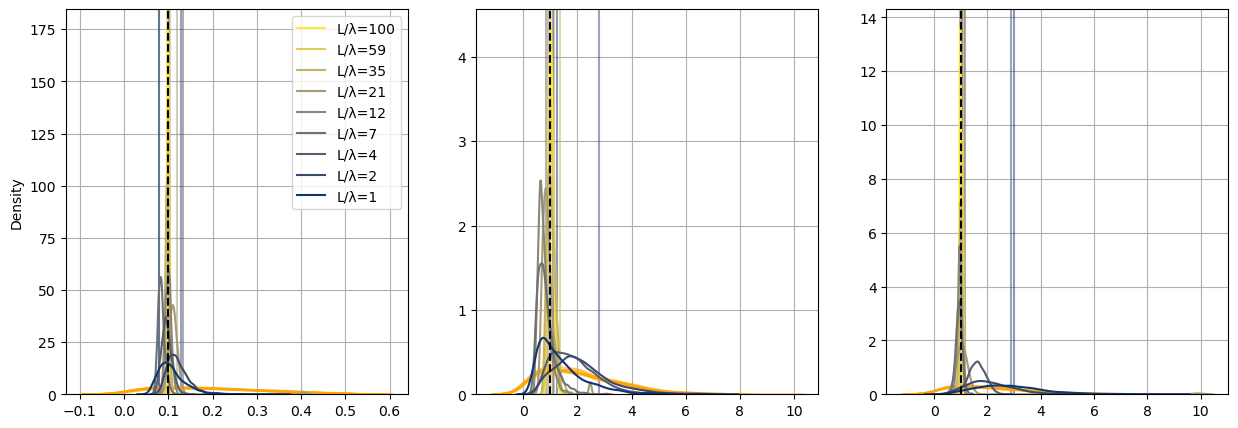

In [14]:
plot_marginals(I_L, "L/λ")

In [17]:
def plot_performance0(perf, x, I):

    # extract true values
    ds = I[next(iter(I))]
    noise = float(ds.noise)
    eta = float(ds.eta)
    Lambda = float(ds.Lambda)
    
    fig, axes = plt.subplots(1,3, figsize=(10,3))

    ax = axes[0]
    for q, c in zip(perf["quantile"], ["0.5", "0.5", "0.5"]):
        da = perf["noise_qt"].sel(quantile=q)
        da.plot(x=x, ax=ax, color=c, label=f"q={float(q)}")
    perf["noise_mean"].plot(x=x, ax=ax, color="k", label=f"mean")
    perf["noise_map"].plot(x=x, ax=ax, color="r", label=f"map")
    ax.grid()
    ax.axhline(noise)
    ax.set_ylabel("")
    ax.legend()
    ax.set_title("noise posterior quantiles")

    ax = axes[1]
    for q, c in zip(perf["quantile"], ["0.5", "0.5", "0.5"]):
        da = perf["eta_qt"].sel(quantile=q)
        da.plot(x=x, ax=ax, color=c, label=f"q={float(q)}")
    perf["eta_mean"].plot(x=x, ax=ax, color="k", label=f"mean")
    perf["eta_map"].plot(x=x, ax=ax, color="r", label=f"map")
    ax.grid()
    ax.axhline(eta)
    ax.set_ylabel("")
    ax.set_title("eta posterior quantiles")

    ax = axes[2]
    for q, c in zip(perf["quantile"], ["0.5", "0.5", "0.5"]):
        da = perf["lambda_qt"].sel(quantile=q)
        da.plot(x=x, ax=ax, color=c, label=f"q={float(q)}")
    perf["lambda_mean"].plot(x=x, ax=ax, color="k", label=f"mean")
    perf["lambda_map"].plot(x=x, ax=ax, color="r", label=f"map")
    ax.grid()
    ax.axhline(Lambda)
    ax.set_ylabel("")
    ax.set_title("lambda posterior quantiles")

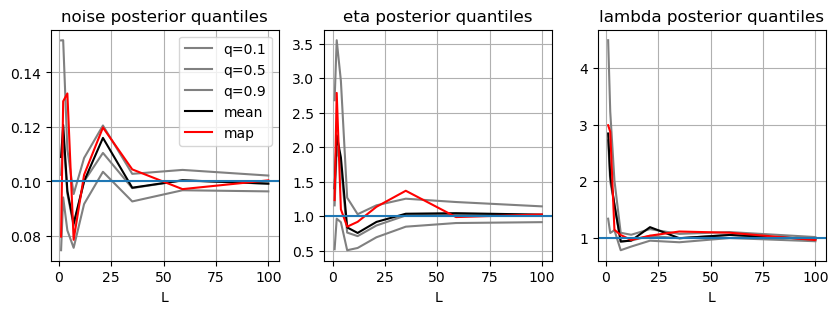

In [18]:
plot_performance0(perf_L, "L", I_L)

In [22]:
def plot_performance1(perf, x, I):

    # extract true values
    ds = I[next(iter(I))]
    noise = float(ds.noise)
    eta = float(ds.eta)
    Lambda = float(ds.Lambda)


    # quantiles to differentiate
    q = (0.1, 0.9)

    fig, axes = plt.subplots(1,3, figsize=(10,3))

    ax = axes[0]

    da = perf["noise_qt"]
    da = da.sel(quantile=q[1]) - da.sel(quantile=q[0])
    da.plot(x=x, ax=ax, color="orange", label=f"q({q[1]}) - q({q[0]})")
    (perf["noise_mean"] - perf.noise).plot(x=x, ax=ax, color="0.5", label=f"mean - truth")
    (perf["noise_map"] - perf.noise).plot(x=x, ax=ax, color="k", label=f"map - truth")
    ax.grid()
    #ax.axhline(noise)
    ax.set_ylabel("")
    ax.legend()
    ax.set_title("noise")

    ax = axes[1]
    da = perf["eta_qt"]
    da = da.sel(quantile=q[1]) - da.sel(quantile=q[0])
    da.plot(x=x, ax=ax, color="orange", label=f"q({q[1]}) - q({q[0]})")
    (perf["eta_mean"] - perf.eta).plot(x=x, ax=ax, color="0.5", label=f"mean - truth")
    (perf["eta_map"] - perf.eta).plot(x=x, ax=ax, color="k", label=f"map - truth")
    ax.grid()
    ax.set_ylabel("")
    ax.set_title("eta")

    ax = axes[2]
    da = perf["lambda_qt"]
    da = da.sel(quantile=q[1]) - da.sel(quantile=q[0])
    da.plot(x=x, ax=ax, color="orange", label=f"q({q[1]}) - q({q[0]})")
    (perf["lambda_mean"] - perf.Lambda).plot(x=x, ax=ax, color="0.5", label=f"mean - truth")
    (perf["lambda_map"] - perf.Lambda).plot(x=x, ax=ax, color="k", label=f"map - truth")
    ax.grid()
    ax.set_ylabel("")
    ax.set_title("lambda")

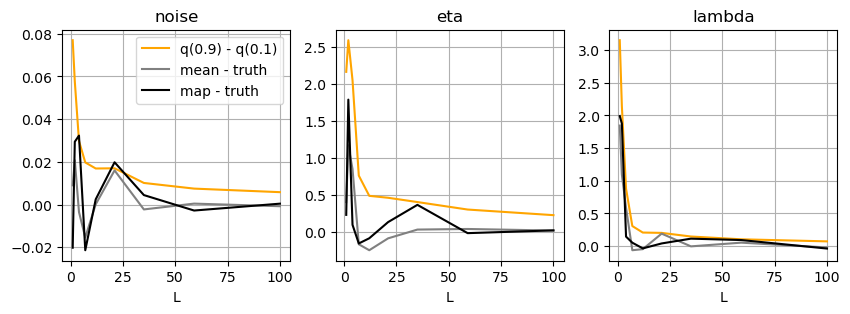

In [23]:
plot_performance1(perf_L, "L", I_L)

---
### resolution (δ) sensitivity

Central result: a minimal resolution, e.g. $\delta\ge2\lambda$ is sufficient to distinguish the signal from noise

In [48]:
I_d = {}

#δ = np.arange(.05, .55, .05)[::-1]
δ = 1/np.arange(1., 16., 1.)

print(δ)
for d in tqdm(δ):
    d_inv = 1/d
    I_d[d_inv] = run_inference_experiment(δ=d)

perf_d = aggregate_perf_indicators(I_d, "λ/δ")

[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857 0.06666667]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [54:27<00:00, 217.80s/it]


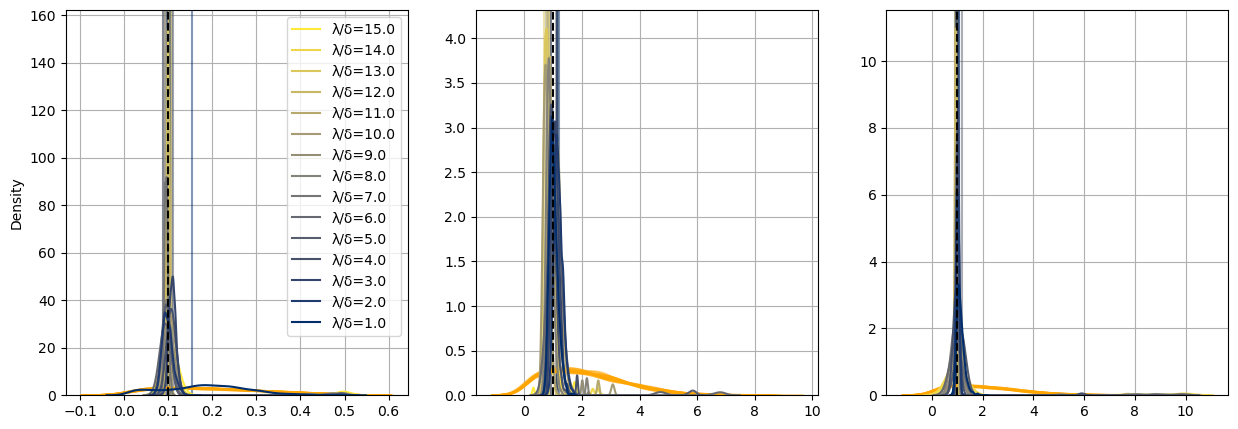

In [49]:
plot_marginals(I_d, "λ/δ")

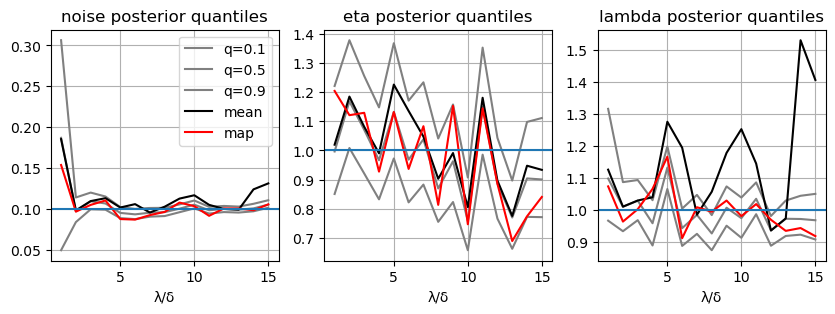

In [52]:
plot_performance0(perf_d, "λ/δ", I_d)

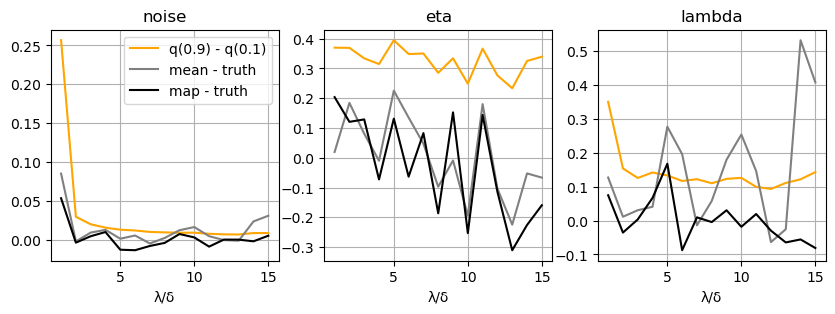

In [53]:
plot_performance1(perf_d, "λ/δ", I_d)

---
## random sampling

Points are now distributed randomly over the domain.
The number of points is specified by $\delta$ via $N=L/\delta$.


In [54]:
I_L_nu = {}

L = np.logspace(0, 2, 10, dtype=int)

print(L)
for l in tqdm(L):
    I_L_nu[l] = run_inference_experiment(L=l, sampling="random")
    
perf_L_nu = aggregate_perf_indicators(I_L_nu, "L")

[  1   1   2   4   7  12  21  35  59 100]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [30:48<00:00, 184.87s/it]


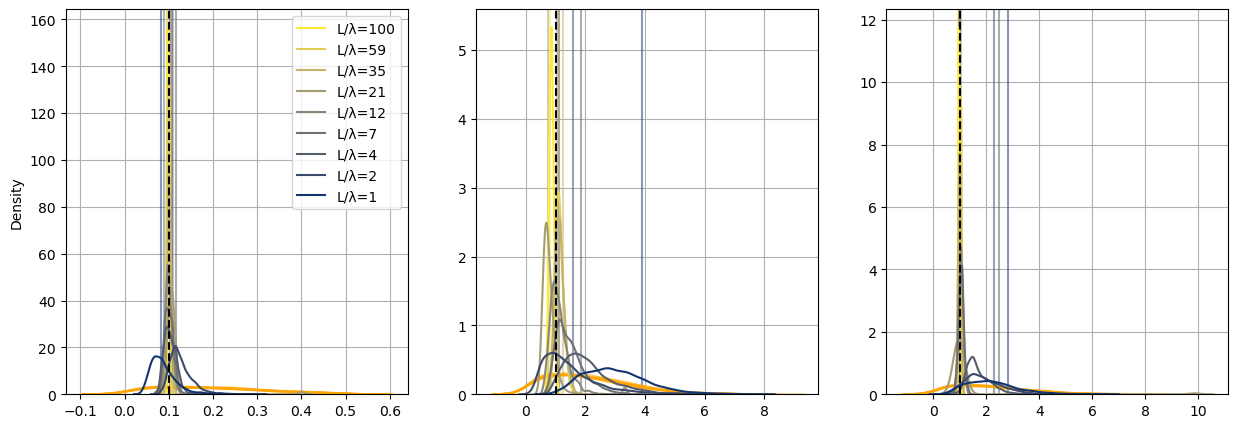

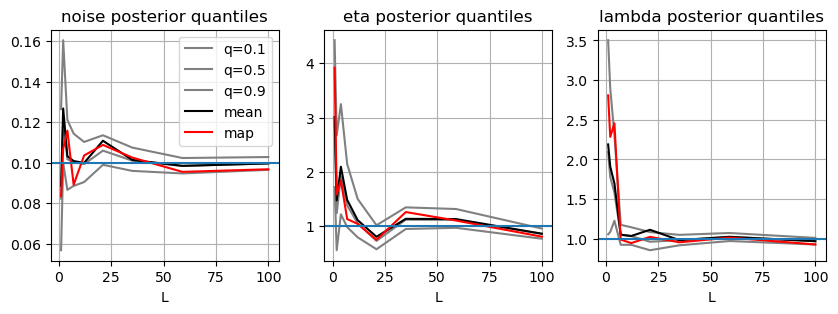

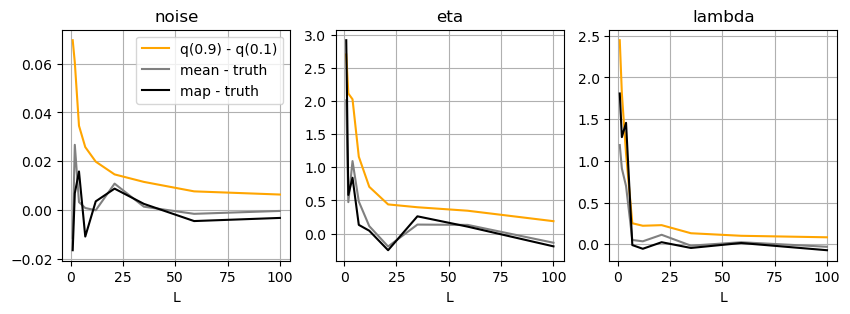

In [55]:
plot_marginals(I_L_nu, "L/λ")
plot_performance0(perf_L_nu, "L", I_L_nu)
plot_performance1(perf_L_nu, "L", I_L_nu)

In [56]:
I_d_nu = {}

#δ = np.arange(.05, .55, .05)[::-1]
δ = 1/np.arange(1., 15., 1.)

print(δ)
for d in tqdm(δ):
    d_inv = 1/d
    I_d_nu[d_inv] = run_inference_experiment(δ=d, sampling="random")
    
perf_d_nu = aggregate_perf_indicators(I_d_nu, "λ/δ")

[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [41:16<00:00, 176.91s/it]


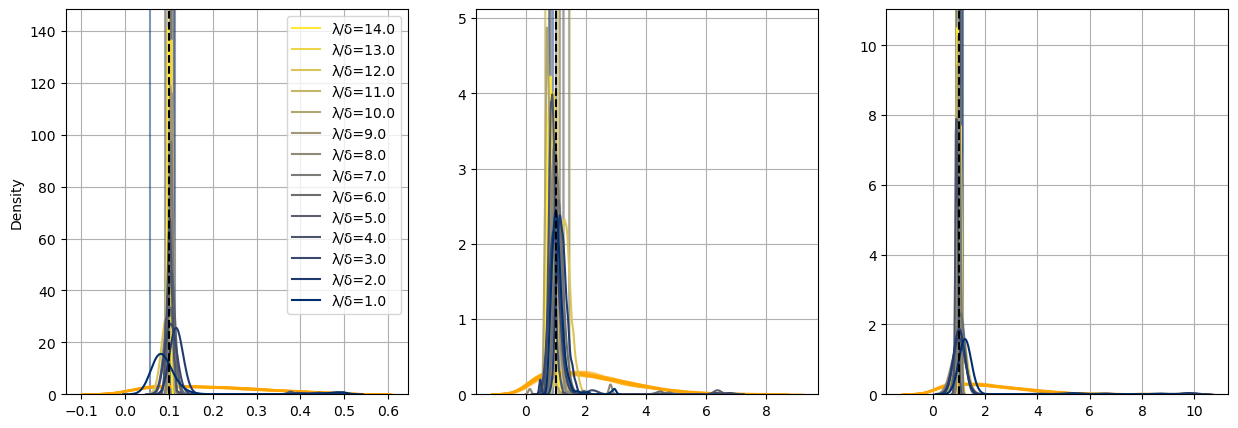

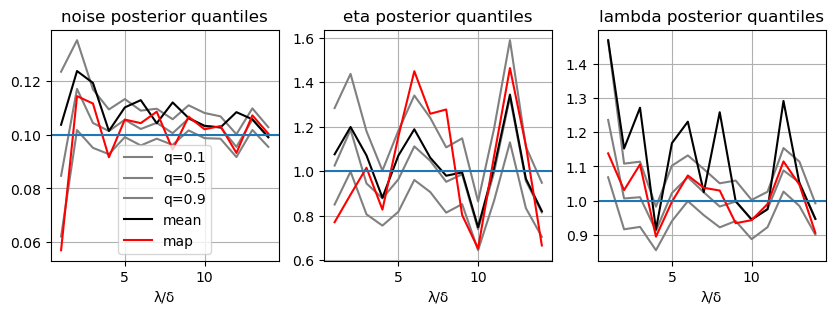

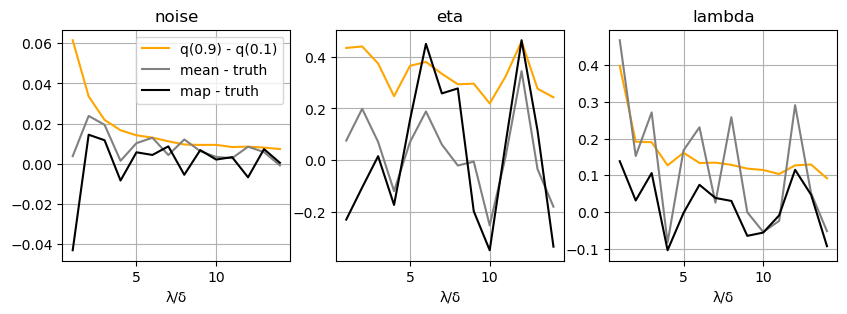

In [57]:
plot_marginals(I_d_nu, "λ/δ")
plot_performance0(perf_d_nu, "λ/δ", I_d_nu)
plot_performance1(perf_d_nu, "λ/δ", I_d_nu)